In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
from torchvision import transforms 
import torchvision.datasets as  datasets 
import torch.optim as optim 
from torchvision.utils import make_grid 


In [8]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [19]:
torch.device(device)

device(type='cpu')

In [ ]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

In [12]:
data_variance = np.var(training_data.data / 255.0)

In [13]:
data_variance 

0.06328692405746414

In [14]:
len(training_data.data)

50000

In [10]:
class VectorQuentizer(nn.Module):
    def __init__(self , embedding_dim , num_embeddings , comitment_cost):
        super().__init__()
        self._embedding_dim  = embedding_dim 
        self._num_embeddings = num_embeddings 
        self._comitment_cost = comitment_cost
        self._embeddings = nn.Embedding(self._num_embeddings  , self._embedding_dim)
        self._embeddings.weight.data.uniform_(-1/self._num_embeddings,  1/self._num_embeddings)
        
    def forward(self, inputs):
        inputs  = inputs.permute( 0 ,2 ,3,1)
        input_shape = inputs.shape
        flat_input = inputs.view(-1,self._embeddings)
        
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        encoding_indices = torch.argmin(distances  , dim  =1 ).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0] ,self._embeddings.weight).view(input_shape)
        encodings.scatter_(1 , encoding_indices , 1 )
                
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [11]:
class VecotorQuentizerEMA(nn.Module):
    def __init__(self , num_embeddings ,embedding_dim , comitment_cost , decay, epsilon  =1e-5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim  = embedding_dim 
        self.comitment_cost = comitment_cost 
        self._embedding = nn.Embedding(self.num_embeddings , self.embedding_dim)
        self._embedding.weight.data.normal_()
        self.register_buffer('_ema_cluster_size' , torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings , self.embedding_dim))
        self._ema_w.data.normal_()
        self.decay = decay
        self.epsilon  = epsilon 
        
    def forward(self,inputs):
        inputs = inputs.permute(0 , 2, 3,1).contiguous()
        input_shape = inputs.shape
        flat_input = inputs.view(-1 , self.embedding_dim)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        encoding_indices = torch.argmin(distances , dim =1 ).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0] ,self.num_embeddings ,device = inputs.device)
        encodings.scatter_(1,encoding_indices , 1)
        quantized = torch.matmul(encodings , self._embedding.weight).view(inputs.shape)
        
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self.decay + (1 -self.decay) * torch.sum(encodings ,  0)
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = ((self._ema_cluster_size + self.epsilon ) / (n + self.num_embeddings * self.epsilon) * n)
            dw = torch.matmul(encodings.t() ,flat_input )
            self._ema_w = nn.Parameter(self._ema_w * self.decay  + (1 - self.decay)* dw )
            self._embedding.weight = nn.Parameter(self._ema_w  / self._ema_cluster_size.unsqueeze(1))
            
            e_latent_loss = F.mse_loss(quantized.detach(), inputs)
            loss = self.comitment_cost * e_latent_loss

            # Straight Through Estimator
            quantized = inputs + (quantized - inputs).detach()
            avg_probs = torch.mean(encodings, dim=0)
            perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

            # convert quantized from BHWC -> BCHW
            return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


In [12]:
class Residual(nn.Module):
    def __init__(self , in_channels , num_hidden , num_residual_hiddens):
        super().__init__()
        self.block  = nn.Sequential(
            nn.ReLU(True) ,
            nn.Conv2d(in_channels= in_channels , out_channels= num_residual_hiddens , stride= 1 , kernel_size=3 , padding = 1 , bias = False),
            nn.ReLU(True),
            nn.Conv2d(in_channels  = num_residual_hiddens  , out_channels  =num_hidden , stride = 1 , kernel_size = 1  , bias = False)
            
        )
        
    def forward(self , x):
            return x +  self.block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hidden, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    

In [13]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens//2,
                                 kernel_size=4,stride=2, padding=1)
        
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2, out_channels=num_hiddens,
                                 kernel_size=4, stride=2, padding=1)
        
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens, out_channels=num_hiddens,
                                 kernel_size=3,stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,num_hidden=num_hiddens,
                                             num_residual_layers=num_residual_layers,num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)
    
        

            
            
# Decoder 

class Decoder(nn.Module):
    def __init__(self , in_channels , num_hidden , num_residual_layers , num_residual_hidden):
        super().__init__()
        self._conv1_ = nn.Conv2d(in_channels   = in_channels    , out_channels = num_hidden ,
                                 kernel_size= 3 , stride = 1 , padding =1)
        
        self._residual_stack_ =  ResidualStack(in_channels  = num_hidden ,
                                               num_hidden = num_hidden , num_residual_layers = num_residual_layers   ,
                                               num_residual_hiddens  = num_residual_hidden) 
        
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hidden , out_channels= num_hidden // 2 , 
                                                kernel_size= 4 , stride=2 , padding =1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels = num_hidden //2 , kernel_size= 4,
                                                out_channels= 3  , stride = 2 ,  padding = 1)
        
    def forward(self, x ):
        x = self._conv1_(x)
        x = self._residual_stack_(x)
        x = self._conv_trans_1(x)
        x = F.relu(x)
        x = self._conv_trans_2(x)
        return x 


In [14]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3


In [63]:
training_loader   = DataLoader(training_data , batch_size= batch_size , pin_memory=  True  , shuffle= True )
validation_loader =  DataLoader(validation_data , batch_size= batch_size , pin_memory= True , shuffle= True)

In [15]:
class Model(nn.Module):
    def __init__(self , num_hidden , num_residual_layers , num_residual_hidden , num_embeddings , embdding_dim , comiment_cost  , decay = 0):
        super().__init__()
        self._encoder = Encoder(3 ,num_hidden , num_residual_layers , num_residual_hidden )
        self._pre_vq_conv = nn.Conv2d(in_channels  =num_hidden , out_channels=embdding_dim , kernel_size=1 , stride=1 )
        
        if decay > 0.0:
            self._vq_vae =  VecotorQuentizerEMA(num_embeddings  , embedding_dim , comiment_cost , decay)
        else:
            self._vq_vae  = VectorQuentizer(num_embeddings , embedding_dim , comiment_cost )
            
        self._decoder = Decoder(embedding_dim , num_hidden  , num_residual_layers , num_residual_hidden)
        
    def forward(self, x):
        y = self._encoder(x)
        y =  self._pre_vq_conv(y)
        loss , quentized , perplexity , _ = self._vq_vae(y)
        x_recon = self._decoder(quentized )
        return loss , x_recon , perplexity 

In [16]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [232]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [234]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.995
perplexity: 1.000

200 iterations
recon_error: 0.986
perplexity: 1.000

300 iterations
recon_error: 0.986
perplexity: 1.000

400 iterations
recon_error: 0.981
perplexity: 1.000

500 iterations
recon_error: 0.977
perplexity: 1.000

600 iterations
recon_error: 0.747
perplexity: 2.705

700 iterations
recon_error: 0.394
perplexity: 3.778

800 iterations
recon_error: 0.261
perplexity: 5.492

900 iterations
recon_error: 0.231
perplexity: 8.414

1000 iterations
recon_error: 0.204
perplexity: 14.173

1100 iterations
recon_error: 0.179
perplexity: 17.706

1200 iterations
recon_error: 0.163
perplexity: 20.427

1300 iterations
recon_error: 0.153
perplexity: 24.549

1400 iterations
recon_error: 0.146
perplexity: 26.655

1500 iterations
recon_error: 0.140
perplexity: 28.162

1600 iterations
recon_error: 0.134
perplexity: 29.460

1700 iterations
recon_error: 0.127
perplexity: 30.583

1800 iterations
recon_error: 0.123
perplexity: 31.636

1900 iterations
recon_error:

In [236]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
from scipy.signal import savgol_filter

train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

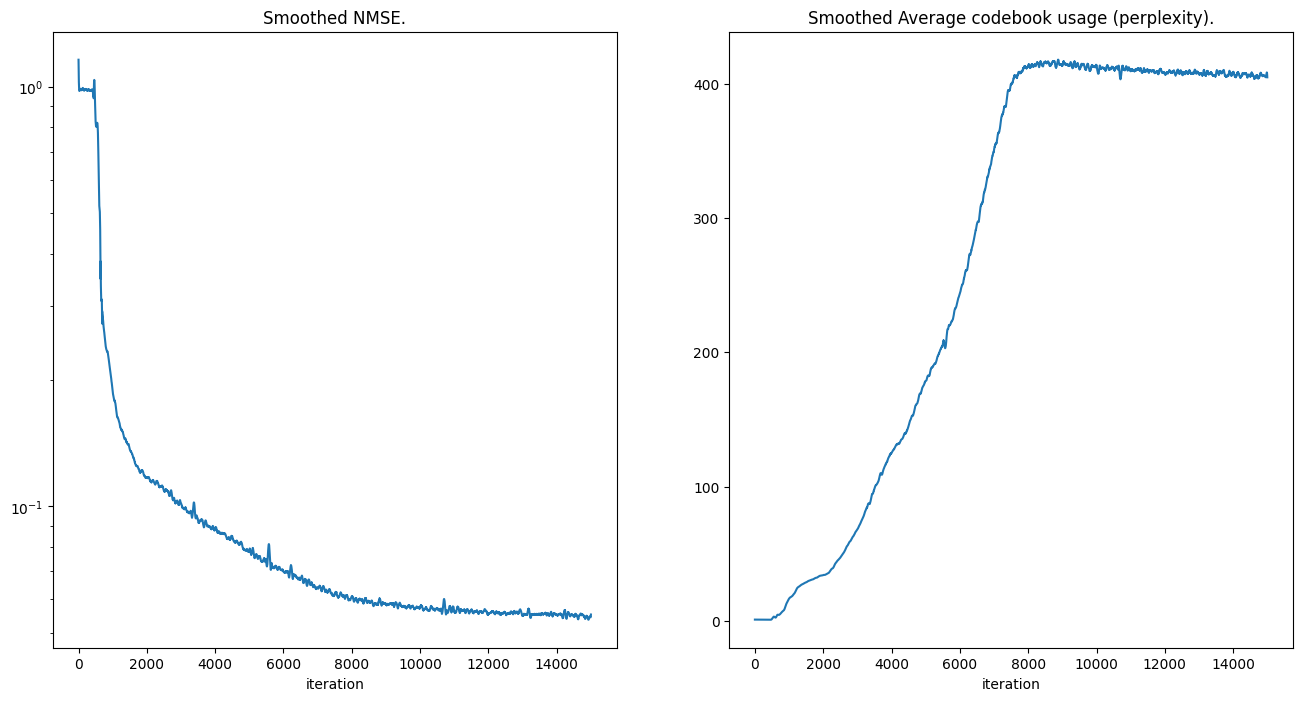

In [240]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [241]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [242]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [243]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

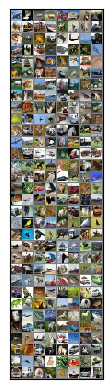

In [244]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

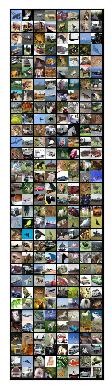

In [245]:
show(make_grid(valid_originals.cpu()+0.5))